<a href="https://colab.research.google.com/github/160445092/EEG_classification/blob/main/conv2d_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.io as sio
import h5py
import numpy as np
import tensorflow as tf
from google.colab import drive
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import layers

from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
#ファイルの読み込み
def import_data(every=False):
    if every:
        electrodes = 25
    else:
        electrodes = 22
    X, y = [], []
    drive_root_dir="./gdrive/My Drive/data"
    for i in range(9):
        A01T = h5py.File(drive_root_dir + "/A0" + str(i + 1) + 'T_slice.mat', 'r')
        X1 = np.copy(A01T['image'])
        X.append(X1[:, :electrodes, :])
        y1 = np.copy(A01T['type'])
        y1 = y1[0, 0:X1.shape[0]:1]
        y.append(np.asarray(y1, dtype=np.int32))

    for subject in range(9):
        delete_list = []
        for trial in range(288):
            if np.isnan(X[subject][trial, :, :]).sum() > 0:
                delete_list.append(trial)
        X[subject] = np.delete(X[subject], delete_list, 0)
        y[subject] = np.delete(y[subject], delete_list)
    y = [y[i] - np.min(y[i]) for i in range(len(y))]
    return X, y


In [3]:
#データの変換
def train_test_subject(X, y, train_all=True, standardize=True):

    l = np.random.permutation(len(X[0]))
    X_test = X[0][l[:50], :, :]
    y_test = y[0][l[:50]]

    if train_all:
        X_train = np.concatenate((X[0][l[50:], :, :], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8]))
        y_train = np.concatenate((y[0][l[50:]], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8]))

    else:
        X_train = X[0][l[50:], :, :]
        y_train = y[0][l[50:]]

    X_train_mean = X_train.mean(0)
    X_train_var = np.sqrt(X_train.var(0))

    if standardize:
        X_train -= X_train_mean
        X_train /= X_train_var
        X_test -= X_train_mean
        X_test /= X_train_var

    X_train = np.transpose(X_train, (0, 2, 1))
    X_test = np.transpose(X_test, (0, 2, 1))

    return X_train, X_test, y_train, y_test


In [4]:
X, y = import_data(every=False)
X_train,X_test,y_train,y_test = train_test_subject(X, y)

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train.shape))
print ('Test target shape: {}'.format(y_test.shape))
#print ('Person train/valid shape: {}'.format(person_train_valid.shape))
#print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2508, 1000, 22)
Test data shape: (50, 1000, 22)
Training/Valid target shape: (2508,)
Test target shape: (50,)


In [15]:
x_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, X_train.shape[2])
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, X_test.shape[2])
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)
print ('Training/Valid data shape: {}'.format(x_train.shape))
print ('Test data shape: {}'.format(x_test.shape))
print ('Training/Valid target shape: {}'.format(y_train.shape))
print ('Test target shape: {}'.format(y_test.shape))

Training/Valid data shape: (2508, 1000, 1, 22)
Test data shape: (50, 1000, 1, 22)
Training/Valid target shape: (2508, 4)
Test target shape: (50, 4)


In [16]:
from keras import regularizers as reg
from keras.layers import Conv1D,Conv2D,MaxPooling1D,Flatten,Dense,Dropout,BatchNormalization, GRU, LSTM, RNN
import matplotlib.pyplot as plt

learning_rate_list = [1e-4, 5e-4, 1e-3]
model_list         = []
cmax               = 0 

for learning_rate in learning_rate_list:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1), strides = (3,1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
#    model.summary()
    model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_test, y_test), verbose=False)
    score = model.evaluate(x_test, y_test, verbose=0)
    if(score[1]>cmax):
      cmax = score[1]
      parameters =  learning_rate
      model_max  = model
    model_list.append(model)

print ("Optimal learning rate: " +str(parameters) )

score = model_max.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Validation accuracy overall w/o dropout bn:', score[1]) 



Optimal learning rate: 0.0001

 Validation accuracy overall w/o dropout bn: 0.41999998688697815


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 998, 64)           4288      
_________________________________________________________________
batch_normalization_8 (Batch (None, 998, 64)           256       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 499, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 497, 64)           12352     
_________________________________________________________________
batch_normalization_9 (Batch (None, 497, 64)           256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 248, 64)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 15872)            

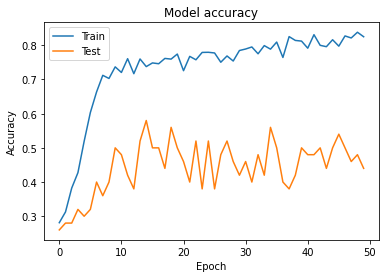

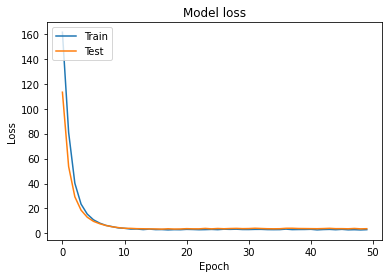

In [ ]:
cnn(conv_layers=2,conv_sizes=(64,64),fc_layers=3,fc_sizes=(1024,512,256))

In [ ]:
X, y = import_data(every=False)
X_train,X_test,y_train,y_test = train_test_subject(X, y)
cnn_plot(conv_layers=2,conv_sizes=(64,128),fc_layers=3,fc_sizes=(1024,512,256))

NameError: ignored

In [ ]:
print(X_train.shape[1:])

(1000, 22)
